In [1]:
from exprel.dataset.semeval_dataset import SemevalDataset
import exprel.utils
from dotenv import load_dotenv 
load_dotenv()

True

In [2]:
data = SemevalDataset("/home/kovacs/projects/exp-relation-extraction/data/semeval_train.txt")

2021-04-07 10:37:36 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

/home/kovacs/miniconda3/envs/rel/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2021-04-07 10:37:36 INFO: Use device: cpu
2021-04-07 10:37:36 INFO: Loading: tokenize
2021-04-07 10:37:36 INFO: Loading: pos
2021-04-07 10:37:37 INFO: Lo

In [3]:
data.load_graphs("pickle.dat")

In [4]:
df = data.to_dataframe()

In [5]:
len(df)

8000

In [120]:
df.groupby("label").size()

label
Cause-Effect(e1,e2)           344
Cause-Effect(e2,e1)           659
Component-Whole(e1,e2)        470
Component-Whole(e2,e1)        471
Content-Container(e1,e2)      374
Content-Container(e2,e1)      166
Entity-Destination(e1,e2)     844
Entity-Destination(e2,e1)       1
Entity-Origin(e1,e2)          568
Entity-Origin(e2,e1)          148
Instrument-Agency(e1,e2)       97
Instrument-Agency(e2,e1)      407
Member-Collection(e1,e2)       78
Member-Collection(e2,e1)      612
Message-Topic(e1,e2)          490
Message-Topic(e2,e1)          144
Other                        1410
Product-Producer(e1,e2)       323
Product-Producer(e2,e1)       394
dtype: int64

In [7]:
one_versus_rest = data.one_versus_rest(df, "Entity-Destination(e1,e2)")

In [8]:
one_versus_rest.iloc[0].sentence

'The system as described above has its greatest application in an arrayed configuration of antenna elements.'

In [9]:
import pandas as pd

ids = pd.to_numeric(one_versus_rest.sen_id).tolist()
sentences = one_versus_rest.sentence.tolist()
labels = one_versus_rest.one_versus_rest.tolist()
postprocessed_graphs = one_versus_rest.graph.tolist()

In [10]:
labels.count(1)

844

In [11]:
labels.count(0)

7156

In [12]:
from exprel.feature_extractor.extract import FeatureExtractor
from exprel.models.model import GraphModel

extractor = FeatureExtractor()
model = GraphModel()

In [13]:
from tqdm import tqdm

for ind, graph, label in tqdm(zip(ids, postprocessed_graphs, labels)):
    model.featurize_sen_graph(ind, graph, label, 3)

8000it [01:45, 75.88it/s] 


In [14]:
model.vocab_size

499095

In [15]:
model.select_n_best(7000)

In [16]:
X, Y = model.get_x_y(one_versus_rest.one_versus_rest.tolist())

In [122]:
list(tst_labels).count(1)

259

In [18]:
from sklearn.model_selection import train_test_split as split

tr_data,tst_data,tr_labels,tst_labels = split(X,Y, test_size=0.3, random_state=1234)

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(tr_data, tr_labels)
#clf = DecisionTreeClassifier(random_state=0, max_depth=4).fit(tr_data, tr_labels)

In [97]:
from sklearn.metrics import precision_recall_fscore_support

lr_pred = clf.predict(tst_data)
for pcf in precision_recall_fscore_support(tst_labels, lr_pred, average=None):
    print(pcf[1])

0.8046875
0.7953667953667953
0.8
259


In [33]:
import numpy as np

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print(indices)

[   1   13   38 ... 4671 4672    0]


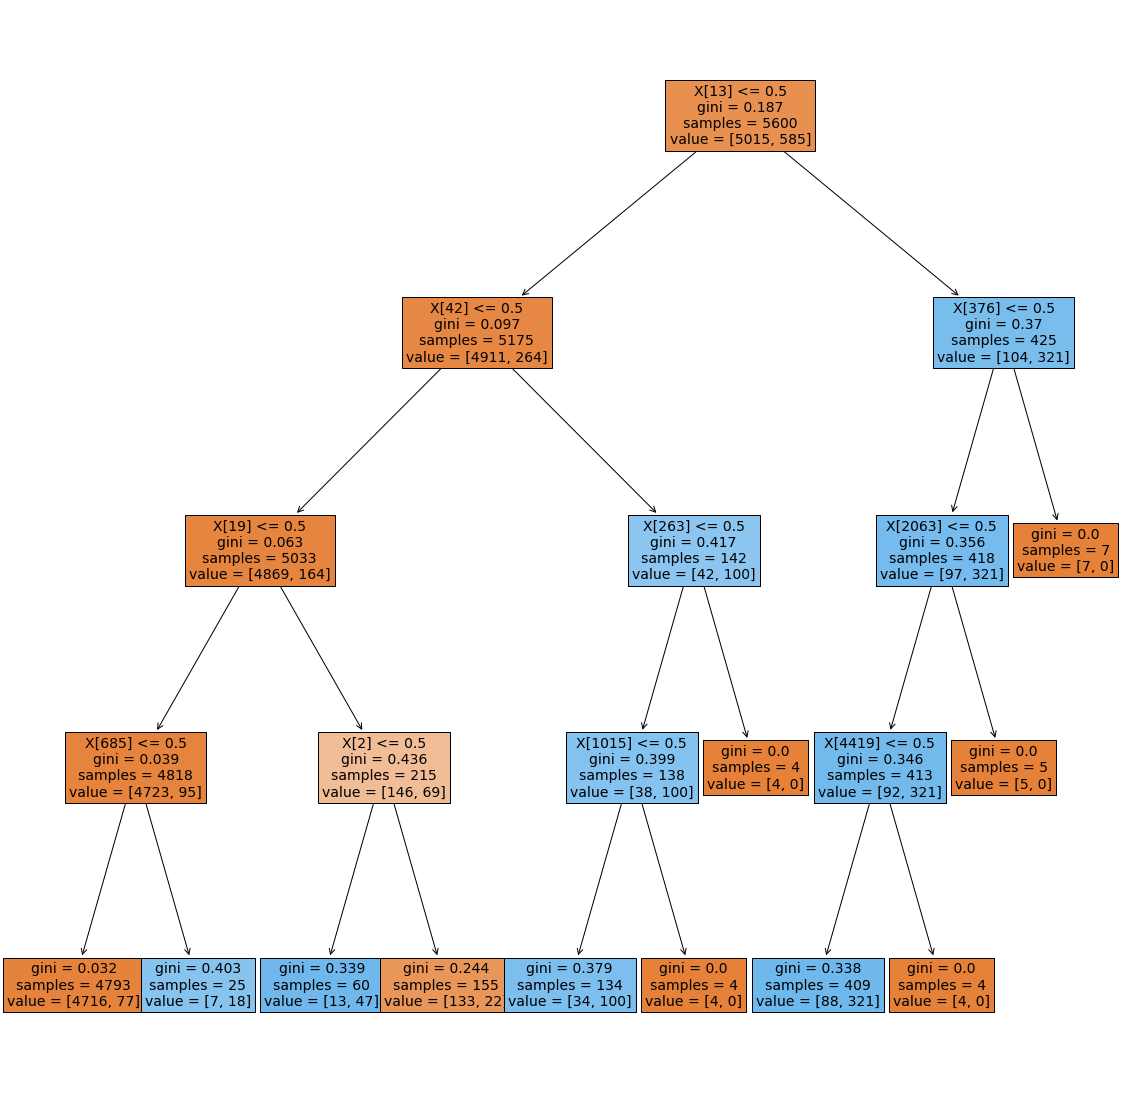

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

from sklearn.tree import plot_tree
t = plot_tree(clf, filled=True, fontsize=14)

In [ ]:
print("hello")

In [ ]:
list(tst_labels).count(1)

In [ ]:
list(lr_pred).count(1)

In [98]:
import eli5

In [99]:
weights_df = eli5.explain_weights_df(clf)

In [100]:
weights_df

,target,feature,weight
0,1.0,x42,3.554073
1,1.0,x19,2.829777
2,1.0,x1992,2.306070
3,1.0,x13,2.115405
4,1.0,x97,1.625335
...,...,...,...
6357,1.0,x963,-1.105894
6358,1.0,x17,-1.162078
6359,1.0,x376,-1.169265
6360,1.0,x2,-1.343590


In [24]:
feature_graphs = model.get_feature_graphs()

In [29]:
from graphviz import Source
g = feature_graphs[model.inverse_relabel[1]]
Source(to_dot(g))

NameError: name 'to_dot' is not defined

In [25]:
feature_graph_strings = model.get_feature_graph_strings()

In [112]:
features = []
most_important_weights = weights_df.iloc[:5].feature.str.strip("x").tolist()
for i in most_important_weights:
    g_nx = feature_graphs[model.inverse_relabel[int(i)]]
    if len(g_nx.edges()):
        g = feature_graph_strings[model.inverse_relabel[int(i)]]
        features.append((g, 1))

In [113]:
features

[('(u_29 / to  :2 (u_4 / entity2))', 1),
 ('(u_26 / into  :2 (u_4 / entity2))', 1),
 ('(u_82 / place  :2 (u_2 / entity1))', 1)]

In [114]:
extractor.set_matcher(features)

In [115]:
_, val = split(one_versus_rest, test_size=0.3, random_state=1234) 

In [116]:
val_graphs = val.graph.tolist()
val_labels = val.one_versus_rest.tolist()

In [117]:
val_predicted = []
for g in val_graphs:
    feats = extractor.matcher.match(g)
    label = 0
    for feat in feats:
        label = feat
    val_predicted.append(label)

In [118]:
val_predicted.count(1)

270

In [119]:
from sklearn.metrics import precision_recall_fscore_support
for pcf in precision_recall_fscore_support(val_labels, val_predicted, average=None):
    print(pcf[1])

0.7111111111111111
0.7413127413127413
0.7258979206049149
259


In [113]:
import networkx as nx
all_features = nx.MultiDiGraph()

In [114]:
for i, t in enumerate(weights_df.iloc[:10].feature.str.strip("x").tolist()):
    node_to_string = {}
    g = feature_graphs[model.inverse_relabel[int(t)]]
    nodes = []
    for n in g.nodes(data=True):
        n_post = n[1]["name"]+"_feature"+str(i)
        nodes.append(n_post)
        node_to_string[n[0]] = n_post
    all_features.add_nodes_from(nodes)
    
    for e in g.edges(data=True):
        all_features.add_edge(node_to_string[e[0]], node_to_string[e[1]], color=e[2]["color"])
        

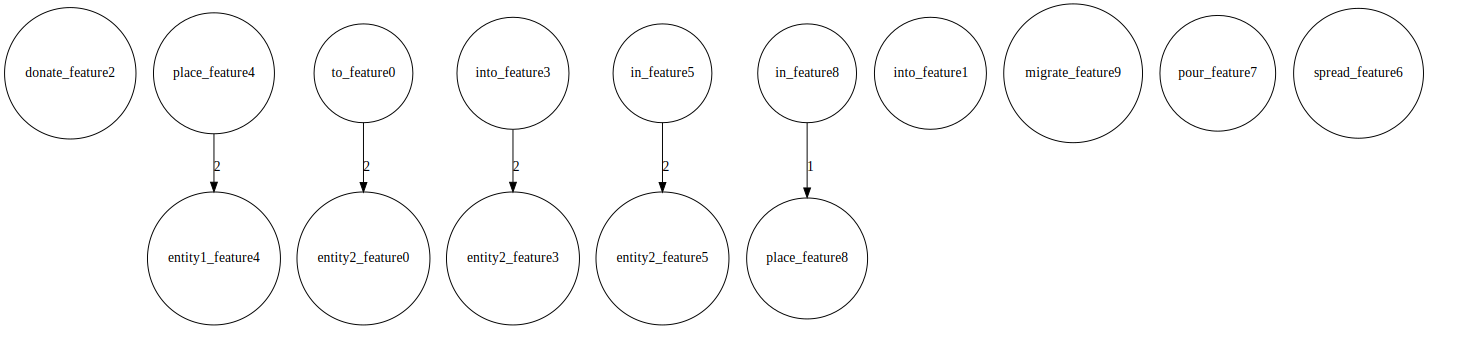

In [115]:
from graphviz import Digraph
from graphviz import Source
# Create Digraph object
dot = to_dot(all_features, integ=True)
Source(dot)

In [ ]:
from graphviz import Digraph
from graphviz import Source
# Create Digraph object
dot = to_dot(feature_graphs[model.inverse_relabel[42]])

In [ ]:
dots = []

for t in weights_df.iloc[:10].feature.str.strip("x").tolist():
    dots.append(feature_graphs[model.inverse_relabel[int(t)]])

Source(to_dots(dots))

In [30]:
import re

def d_clean(string):
    s = string
    for c in '\\=@-,\'".!:;<>/{}[]()#^?':
        s = s.replace(c, '_')
    s = s.replace('$', '_dollars')
    s = s.replace('%', '_percent')
    s = s.replace('|', ' ')
    s = s.replace('*', ' ')
    if s == '#':
        s = '_number'
    keywords = ("graph", "node", "strict", "edge")
    if re.match('^[0-9]', s) or s in keywords:
        s = "X" + s
    return s

def to_dots(graphs, marked_nodes=set(), integ=False):
    lines = [u'digraph finite_state_machine {', '\tdpi=70;']
    # lines.append('\tordering=out;')
    # sorting everything to make the process deterministic
    for i, graph in enumerate(graphs):
        s = "subgraph cluster_" + chr(ord('@')+i+1) + " {"
        node_lines = []

        node_lines.append(s)
        node_to_name = {}
        for node, n_data in graph.nodes(data=True):
            if integ:
                d_node = d_clean(str(node))
            else:    
                d_node = d_clean(n_data["name"])
            printname = d_node
            node_to_name[node] = printname
            if 'expanded' in n_data and n_data['expanded'] and printname in marked_nodes:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style=filled, fillcolor=purple];'.format(
                    d_node, printname).replace('-', '_')
            elif 'expanded' in n_data and n_data['expanded']:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style="filled"];'.format(
                    d_node, printname).replace('-', '_')
            elif 'fourlang' in n_data and n_data['fourlang']:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style="filled", fillcolor=red];'.format(
                    d_node, printname).replace('-', '_')
            elif 'substituted' in n_data and n_data['substituted']:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style="filled"];'.format(
                    d_node, printname).replace('-', '_')
            elif printname in marked_nodes:
                node_line = u'\t{0} [shape = circle, label = "{1}", style=filled, fillcolor=lightblue];'.format(
                    d_node, printname).replace('-', '_')
            else:
                node_line = u'\t{0} [shape = circle, label = "{1}"];'.format(
                    d_node, printname).replace('-', '_')
            node_lines.append(node_line)
        lines += sorted(node_lines)

        edge_lines = []
        for u, v, edata in graph.edges(data=True):
            if 'color' in edata:
                d_node1 = node_to_name[u]
                d_node2 = node_to_name[v]
                edge_lines.append(
                    u'\t{0} -> {1} [ label = "{2}" ];'.format(d_node1, d_node2, edata['color']))

        lines += sorted(edge_lines)
        lines.append('}')
    lines.append('}')
    return u'\n'.join(lines)

def to_dot(graph, marked_nodes=set(), integ=False):
    lines = [u'digraph finite_state_machine {', '\tdpi=70;']
    # lines.append('\tordering=out;')
    # sorting everything to make the process deterministic
    node_lines = []
    node_to_name = {}
    for node, n_data in graph.nodes(data=True):
        if integ:
            d_node = d_clean(str(node))
        else:    
            d_node = d_clean(n_data["name"])
        printname = d_node
        node_to_name[node] = printname
        if 'expanded' in n_data and n_data['expanded'] and printname in marked_nodes:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style=filled, fillcolor=purple];'.format(
                d_node, printname).replace('-', '_')
        elif 'expanded' in n_data and n_data['expanded']:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style="filled"];'.format(
                d_node, printname).replace('-', '_')
        elif 'fourlang' in n_data and n_data['fourlang']:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style="filled", fillcolor=red];'.format(
                d_node, printname).replace('-', '_')
        elif 'substituted' in n_data and n_data['substituted']:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style="filled"];'.format(
                d_node, printname).replace('-', '_')
        elif printname in marked_nodes:
            node_line = u'\t{0} [shape = circle, label = "{1}", style=filled, fillcolor=lightblue];'.format(
                d_node, printname).replace('-', '_')
        else:
            node_line = u'\t{0} [shape = circle, label = "{1}"];'.format(
                d_node, printname).replace('-', '_')
        node_lines.append(node_line)
    lines += sorted(node_lines)

    edge_lines = []
    for u, v, edata in graph.edges(data=True):
        if 'color' in edata:
            d_node1 = node_to_name[u]
            d_node2 = node_to_name[v]
            edge_lines.append(
                u'\t{0} -> {1} [ label = "{2}" ];'.format(d_node1, d_node2, edata['color']))

    lines += sorted(edge_lines)
    lines.append('}')
    return u'\n'.join(lines)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
chi2_selector = SelectKBest(chi2, k=10)
X_kbest = chi2_selector.fit_transform(X, Y)

In [ ]:
chi2_selector.get_support(indices=True)

In [ ]:
for i, g in enumerate(feature_graphs):
    if len(g.edges()) != 1:
        print(len(g.edges()))

In [ ]:
dot = to_dot(feature_graphs[2450])
Source(dot)

In [ ]:
dot = to_dot(graphs[0])
Source(dot)

In [ ]:
tests = []

for l in model.lexgraphs.gen_lex_subgraphs(graphs[0], 1):
    print(l)
    tests.append(l[1])

In [ ]:
dot = to_dot(tests[3])
Source(dot)

In [46]:
from networkx.convert import from_dict_of_dicts as fdd
from networkx.convert import to_dict_of_dicts as tdd

H_dict = tdd(graphs[0])
H_dict

{50: {52: {'color': 2}, 86: {'color': 1}},
 52: {59: {'color': 0}, 80: {'color': 0}},
 59: {65: {'color': 0}, 77: {'color': 0}},
 62: {},
 65: {},
 68: {},
 71: {},
 74: {},
 77: {},
 80: {},
 55: {52: {'color': 2}, 56: {'color': 1}},
 56: {},
 83: {},
 86: {50: {'color': 0}, 92: {'color': 0}},
 89: {},
 92: {95: {'color': 0}},
 95: {},
 98: {}}

In [33]:
import pickle
with open("pickle.dat", "rb") as f:
    graphs = pickle.load(f)

In [30]:
for n in graphs[0].nodes(data=True):
    print(n)

(50, {'name': 'have'})
(52, {'name': 'application'})
(59, {'name': 'configuration'})
(62, {'name': 'a'})
(65, {'name': 'element'})
(68, {'name': 'antenna'})
(71, {'name': 'of'})
(74, {'name': 'in'})
(77, {'name': 'array'})
(80, {'name': 'great'})
(55, {'name': 'HAS'})
(56, {'name': 'its'})
(83, {'name': 'PERIOD'})
(86, {'name': 'system'})
(89, {'name': 'the'})
(92, {'name': 'describe'})
(95, {'name': 'above'})
(98, {'name': 'as'})


In [52]:
import networkx as nx
G = nx.MultiDiGraph()

C = fdd(H_dict,create_using=nx.MultiDiGraph())

[(23, 4), (25, 0), (33, 1), (36, 0), (39, 0), (42, 2), (28, 2), (29, 1)]


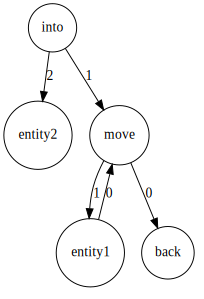

In [83]:
from graphviz import Digraph
from graphviz import Source

outdeg = graphs[7].degree()
print(outdeg)

to_keep = [n for (n, deg) in outdeg if deg != 0]
G = graphs[7].subgraph(to_keep)
dot = to_dot(G, integ=False)
Source(dot)

In [70]:
import networkx as nx


def gen_subgraphs(M, no_edges):
    """M must be dict of dicts, see networkx.convert.to_dict_of_dicts.
    Generates dicts of dicts, use networkx.convert.from_dict_of_dicts"""
    if no_edges == 0:
        yield from ({v: {}} for v in M)
        return
    for s_graph in gen_subgraphs(M, no_edges-1):
        yield s_graph
        # print('sgraph:', s_graph)
        for node in M:
            for neighbor, edge in M[node].items():
                if node in s_graph and neighbor in s_graph[node]:
                    continue
                if node not in s_graph and neighbor not in s_graph:
                    continue

                new_graph = s_graph.copy()
                if node not in new_graph:
                    new_graph[node] = {neighbor: edge}
                else:
                    new_graph[node][neighbor] = edge
                yield new_graph

In [107]:
sgraphs = []
for l in model.lexgraphs.gen_lex_subgraphs(G, 1):
    if l[1].edges():
        sgraphs.append(to_dot(l[1]))

In [108]:
len(sgraphs)

10

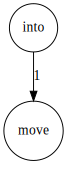

In [110]:
Source(sgraphs[7])

In [ ]:
from collections import Counter

s = Counter()

s["banana"] += 1

In [ ]:
s.most_common(1)